<h1>Cool Maths</h1>

<h2>Local Expensive Min</h2>
<h3>Libraries</h3>

In [111]:
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import pprint
import asyncio
import scipy
import math
import bisect

from matplotlib import gridspec
from scipy import optimize as opt

%reload_ext blackcellmagic

<h3>Functions</h3>

In [171]:
def f(x):
    return np.sin(x) + 0.05 * x ** 2


async def slow(x):
    await asyncio.sleep(0.01)
    y = f(x)
    return y * (1 - np.random.normal(size=np.size(y)) * 0.1)


def fit(X, Y):
    guessed = np.polyfit(X, Y, len(X) - 1)
    return lambda x: sum([x ** n * guessed[-(n + 1)] for n in range(len(guessed))])


async def uncertainty(fit, limits, X, x):
    async def height(fit, limits, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        y = fit(x)
        y -= y.min()
        y *= 9.9 / y.max()
        return 10 - y

    async def sparcity(fit, limits, X, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        index = 0
        prob = np.zeros_like(x)
        for j, point in enumerate(x):
            if point == X[index]:
                continue
            else:
                while point > X[index]:
                    index += 1
                prob[j] = min(X[index] - point, point - X[index - 1])
        prob *= 100 / prob.max()
        return prob

    probY = height(approx, limits, x)
    probX = sparcity(approx, limits, X, x)
    return await (probY) * await (probX)


def plotUpdate():
    pass

Guess = -1.4352785799909957
Real  = -1.427552619970902


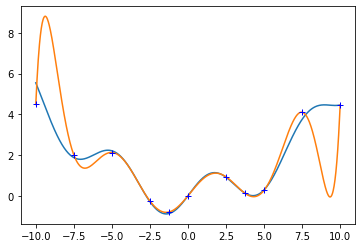

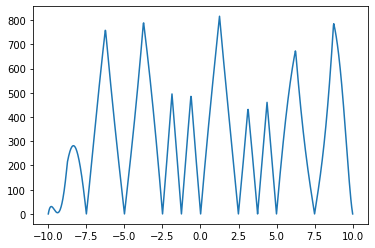

In [173]:
limits = np.array([-10, 10], dtype=float)
x = np.linspace(*limits, 1000)
plt.figure(0)
plt.plot(x, f(x))

X = limits
Y = await slow(limits)

for i in range(9):
    guessed = np.polyfit(X, Y, len(X) - 1)

    approx = fit(X, Y)

    error = await uncertainty(fit, limits, X, x)
    nxt = np.argmax(error)

    index = bisect.bisect(X, x[nxt])
    X = np.insert(X, index, x[nxt])
    Y = np.insert(Y, index, await slow(x[nxt]))

approx = fit(X, Y)
error = await uncertainty(approx, limits, X, x)

plt.figure(0)
plt.plot(x, approx(x))
plt.figure(0)
plt.plot(X, Y, "b+")
plt.figure(1)
plt.plot(x, error)

print(f"Guess = {opt.fminbound(approx, *limits, disp = 0)}")
print(f"Real  = {opt.fminbound(f, *limits, disp = 0)}")

x